In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("../data/combined.csv")

## Minor Transforms

In [3]:
df = df.drop(['Pos_y', 'GP_y'], axis = 1)
df = df.rename(columns={"Pos_x": "Pos", "GP_x": "GP"})

In [4]:
def get_seconds(time_str):
    # split in hh, mm, ss
    mm, ss = time_str.split(':')
    return int(mm) * 60 + int(ss)

In [5]:
df['TOI/60'] = df['TOI/60'].apply(lambda x: get_seconds(x))
df['ATOI'] = df['ATOI'].apply(lambda x: get_seconds(x))
df['TOI(EV)'] = df['TOI(EV)'].apply(lambda x: get_seconds(x))

Lets see if we can develop a model to predict goals. Lets take a look at the correlation coefficients again.

<AxesSubplot:>

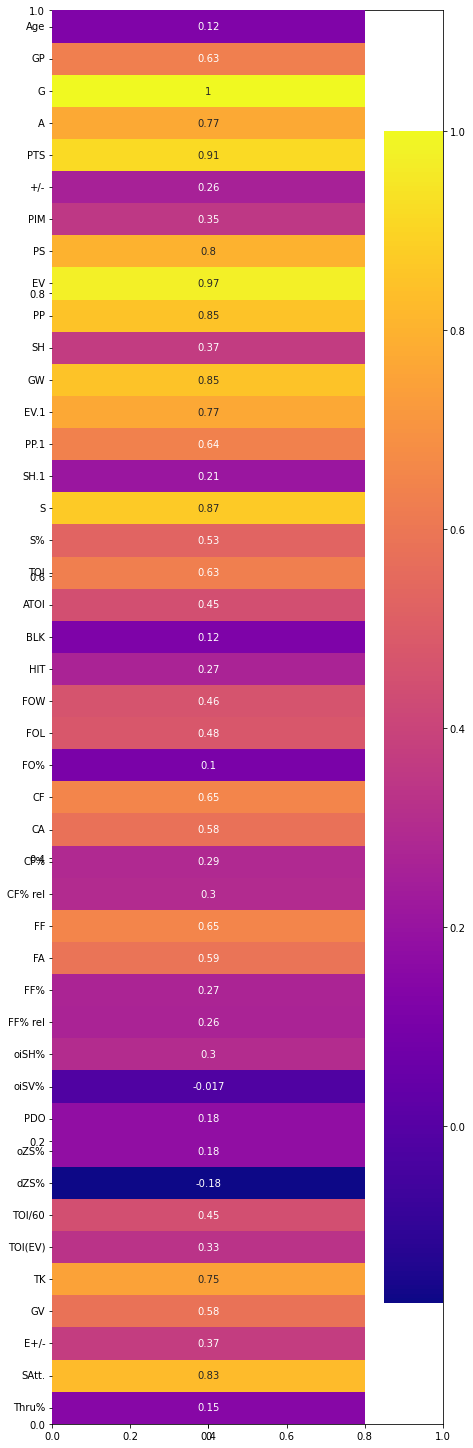

In [6]:
plt.subplots(figsize=(7, 26))
ax = plt.axes()
corr = df.corrwith(df['G'])
corr = pd.DataFrame(corr)
corr = corr.rename(columns={"0": "G"})


sns.heatmap(corr,
            annot=True,
            cmap = plt.cm.plasma)

## Feature Engineering

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 47 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   1003 non-null   object 
 1   Age      1003 non-null   int64  
 2   Tm       1003 non-null   object 
 3   Pos      1003 non-null   object 
 4   GP       1003 non-null   int64  
 5   G        1003 non-null   int64  
 6   A        1003 non-null   int64  
 7   PTS      1003 non-null   int64  
 8   +/-      1003 non-null   int64  
 9   PIM      1003 non-null   int64  
 10  PS       1003 non-null   float64
 11  EV       1003 non-null   int64  
 12  PP       1003 non-null   int64  
 13  SH       1003 non-null   int64  
 14  GW       1003 non-null   int64  
 15  EV.1     1003 non-null   int64  
 16  PP.1     1003 non-null   int64  
 17  SH.1     1003 non-null   int64  
 18  S        1003 non-null   int64  
 19  S%       975 non-null    float64
 20  TOI      1003 non-null   int64  
 21  ATOI     1003 

In [8]:
df.head()

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,PDO,oZS%,dZS%,TOI/60,TOI(EV),TK,GV,E+/-,SAtt.,Thru%
0,Nicholas Abruzzese,22,TOR,C,9,1,0,1,-1,2,...,98.2,46.3,53.7,613,551,0,3,0.2,12,66.7
1,Noel Acciari,30,FLA,C,20,3,5,8,2,11,...,99.1,52.0,48.0,719,638,8,6,2.7,52,61.5
2,Calen Addison,21,MIN,D,15,2,2,4,-4,2,...,94.4,50.5,49.5,827,736,0,1,3.0,36,47.2
3,Andrew Agozzino,31,OTT,LW,1,0,0,0,0,0,...,100.0,50.0,50.0,412,412,0,0,-0.2,1,100.0
4,Jack Ahcan,24,BOS,D,6,1,0,1,-3,0,...,92.1,59.2,40.8,962,929,1,4,1.2,14,35.7


## Preprocessing

In [9]:
df.isnull().sum()

Player       0
Age          0
Tm           0
Pos          0
GP           0
G            0
A            0
PTS          0
+/-          0
PIM          0
PS           0
EV           0
PP           0
SH           0
GW           0
EV.1         0
PP.1         0
SH.1         0
S            0
S%          28
TOI          0
ATOI         0
BLK          0
HIT          0
FOW          0
FOL          0
FO%        407
CF           0
CA           0
CF%          0
CF% rel      0
FF           0
FA           0
FF%          0
FF% rel      0
oiSH%        2
oiSV%        0
PDO          2
oZS%         3
dZS%         3
TOI/60       0
TOI(EV)      0
TK           0
GV           0
E+/-         0
SAtt.        0
Thru%       12
dtype: int64

In [10]:
df[df.isnull().any(axis=1)]

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,PDO,oZS%,dZS%,TOI/60,TOI(EV),TK,GV,E+/-,SAtt.,Thru%
2,Calen Addison,21,MIN,D,15,2,2,4,-4,2,...,94.4,50.5,49.5,827,736,0,1,3.0,36,47.2
4,Jack Ahcan,24,BOS,D,6,1,0,1,-3,0,...,92.1,59.2,40.8,962,929,1,4,1.2,14,35.7
6,Alexander Alexeyev,22,WSH,D,1,0,0,0,0,2,...,100.0,60.0,40.0,635,607,0,0,0.5,1,0.0
7,Wade Allison,24,PHI,RW,1,0,0,0,-1,0,...,66.7,66.7,33.3,496,425,1,1,-0.1,2,100.0
9,Joey Anderson,23,TOR,RW,5,0,0,0,0,0,...,97.6,75.0,25.0,526,523,2,0,2.0,15,66.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,Nikita Zadorov,26,CGY,D,74,4,18,22,11,77,...,99.8,62.6,37.4,1015,957,32,61,8.1,225,47.1
993,Nikita Zaitsev,30,OTT,D,62,2,9,11,-7,28,...,100.1,34.0,66.0,1139,966,13,35,-9.0,138,47.1
994,Yegor Zamula,21,PHI,D,10,0,0,0,-6,4,...,91.8,50.6,49.4,981,920,3,8,0.6,11,36.4
995,Jakub Zboril,24,BOS,D,10,0,3,3,1,4,...,97.2,58.3,41.7,944,898,1,4,3.0,20,65.0


We can see that we have a few columns that have nulls in them. Particularly faceoff percentage. Since it has a real low correlation coefficient we can remove it from the dataset for now, but perhaps in the future we can experiment with it. Shooting percentage and Percentage of shots taken that go on net have lower correlations (particularly with Thru% which is the latter) with goals but I want to keep it around for a bit. I mean, shouldn't players who get more pucks to the net score more goals? 

Lets make some alterations, remove FO%

In [11]:
df = df.drop('FO%', axis=1)

In [12]:
features_for_imputation = ["S%", "oiSH%", 'PDO', 'oZS%', 'dZS%', 'Thru%']

In [13]:
for key in features_for_imputation:
    imputer_frq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    imputer_frq = imputer_frq.fit(df[[key]])
    df[key] = imputer_frq.transform(df[[key]])

In [14]:
df.isnull().sum()

Player     0
Age        0
Tm         0
Pos        0
GP         0
G          0
A          0
PTS        0
+/-        0
PIM        0
PS         0
EV         0
PP         0
SH         0
GW         0
EV.1       0
PP.1       0
SH.1       0
S          0
S%         0
TOI        0
ATOI       0
BLK        0
HIT        0
FOW        0
FOL        0
CF         0
CA         0
CF%        0
CF% rel    0
FF         0
FA         0
FF%        0
FF% rel    0
oiSH%      0
oiSV%      0
PDO        0
oZS%       0
dZS%       0
TOI/60     0
TOI(EV)    0
TK         0
GV         0
E+/-       0
SAtt.      0
Thru%      0
dtype: int64

Handle TOI features (TOI, ATOI, TOI/60, TOI(EV))

Handle our nominal categorical variables (team and position)

In [ ]:
df_enc = pd.get_dummies(df[['Tm', 'Pos']])

### Dimensionality Reduction